# Fine-tuning models with the kluster.ai API

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kluster-ai/klusterai-cookbook/blob/main/examples/finetuning-sent-analysis.ipynb)

## Introduction

Fine-tuning is the process of refining a pre-trained model's parameters using additional, specialized data to improve performance on a specific task. Fine-tuning can offer valuable benefits: it can significantly improve performance for your specific use case and sometimes rival the results of more expensive, general-purpose models.

In this guide, you'll learn how to train a sentiment analysis model specifically tailored to your data using [kluster.ai](https://www.kluster.ai/). We'll walk through each step of the fine-tuning process—covering dataset setup, environment configuration, and batch inference. By following along, you'll discover how to leverage kluster.ai's powerful platform to create a custom model that boosts accuracy for financial text analysis and beyond.

## Prerequisites

Before getting started, ensure you have the following:

- **A kluster.ai account** - sign up on the <a href="https://platform.kluster.ai/signup" target="_blank">kluster.ai platform</a> if you don't have one
- **A kluster.ai API key** - after signing in, go to the <a href="https://platform.kluster.ai/apikeys" target="_blank">**API Keys**</a> section and create a new key. For detailed instructions, check out the <a href="https://docs.kluster.ai/get-started/get-api-key/" target="_blank">Get an API key</a> guide

## Setup

In this notebook, we'll use Python's `getpass` module to safely input the key. Provide your unique kluster.ai API key (ensure there are no spaces).

In [1]:
from getpass import getpass

api_key = getpass("Enter your kluster.ai API key: ")

Enter your kluster.ai API key: ··········


In [2]:
%pip install -q openai

In [4]:
import urllib.request
import pandas as pd
from openai import OpenAI
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
pd.set_option('display.max_columns', 1000, 'display.width', 1000, 'display.max_rows',1000, 'display.max_colwidth', 500)

# Import helper functions
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/main/examples/helpers.py"

# Fetch the file and save it locally
response = requests.get(url)
with open("helpers.py", "w") as f:
    f.write(response.text)

# Import the helper functions
from helpers import create_tasks, save_tasks, create_batch_job, monitor_job_status, get_results


In [5]:
# Set up the client
client_prod = OpenAI(
    base_url="https://api.kluster.ai/v1",
    api_key=api_key,
)

## Fetch a real dataset for batch inference

This dataset contains a variety of financial news headlines, each labeled as positive, negative, or neutral. In this context, positive indicates a beneficial impact on the company’s stock, negative suggests a detrimental impact, and neutral implies no significant change is expected.

To keep this tutorial quick, we limit the dataset to the first 120 rows of the financial phrasebank, resulting in 12 training examples after splitting. For more robust fine-tuning, we recommend using a larger dataset—though note that kluster.ai requires a minimum of 10 examples.

In [6]:
url = "https://raw.githubusercontent.com/kluster-ai/klusterai-cookbook/main/data/financial-phrasebank.csv"
urllib.request.urlretrieve(url,filename='financial-phrasebank.csv')

# Load and process the dataset based on URL content
df = pd.read_csv('financial-phrasebank.csv', encoding = "ISO-8859-1",header=None, names=["sentiment", "text"])
df = df.iloc[:120]
df.head(3)

,sentiment,text
0,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said ."
2,negative,"The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported ."


### Split data into train/test for fine-tuning

Next, we need to split the data into a training dataset, and testing dataset (to be used later on).

In [7]:
from sklearn.model_selection import train_test_split
# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.9, random_state=42)

In [8]:
len(train_df)

12

## Fine-tuning the model

Fine-tuning is the process of adjusting a pre-trained model with new, domain-specific data to enhance performance for a specific task, which typically reduces training time and costs compared to training from scratch. Additionally, it can allow smaller, fine-tuned models to match or even rival the performance of larger, general models that haven’t been fine-tuned.

In [10]:
SYSTEM_PROMPT = '''
    You are a helpful assistant specializing in determining the sentiment of financial news.
    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.
    Provide your response as a single word without any punctuation.
    '''

# Ensure the directory exists
os.makedirs("finetuning/data", exist_ok=True)

# Generate JSONLines file
with open("finetuning/data/sentiment.jsonl", "w") as f:
    for _, row in train_df.iterrows():
        # Create the message structure
        messages = {
            "messages": [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": row['text']},
                {"role": "assistant", "content": row["sentiment"]}
            ]
        }
        # Write to the file as a single JSON object per line
        f.write(json.dumps(messages) + "\n")

In [11]:
data_dir = 'finetuning/data/sentiment.jsonl'

with open(data_dir, 'rb') as file:
    upload_response = client_prod.files.create(
        file=file,
        purpose="fine-tune"
    )
    file_id = upload_response.id
    print(f"File uploaded successfully. File ID: {file_id}")

File uploaded successfully. File ID: 67b49c04339aa6d8600a1936


Next, we'll submit the job to the kluster.ai fine-tuning API. Currently, two base models are supported for fine-tuning:
- klusterai/Meta-Llama-3.1-8B-Instruct-Turbo
- klusterai/Meta-Llama-3.3-70B-Instruct-Turbo

If you specify a different base model, the fine-tuning job will fail. You can also tweak the hyperparameters (such as number of epochs, batch size, and learning rate) to adjust training time and potential performance gains. Keep in mind that increasing the number of epochs will lead to longer training time, but may result in higher performance. If you're unsure which hyperparameters to set, you can also comment them out to accept the default values.

In [16]:
job = client_prod.fine_tuning.jobs.create(
    training_file=file_id,
    model="klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
    hyperparameters={
       "batch_size": 4,
       "n_epochs": 2,
       "learning_rate_multiplier": 1
    }
)
print("\nFine-tuning job created:")
print(json.dumps(job.model_dump(), indent=2))


Fine-tuning job created:
{
  "id": "67b4a215e56b50d27356ddc1",
  "created_at": 1739891221,
  "error": null,
  "fine_tuned_model": null,
  "finished_at": null,
  "hyperparameters": {
    "batch_size": 4,
    "learning_rate_multiplier": 1.0,
    "n_epochs": 2
  },
  "model": "meta-llama/Llama-3.1-8B-Instruct",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": [],
  "seed": null,
  "status": "queued",
  "trained_tokens": null,
  "training_file": "67b49c04339aa6d8600a1936",
  "validation_file": null,
  "estimated_finish": null,
  "integrations": [],
  "method": {
    "dpo": null,
    "supervised": {
      "hyperparameters": null,
      "batch_size": 4,
      "learning_rate_multiplier": 1,
      "n_epochs": 2
    },
    "type": "supervised"
  }
}


Next, we can retrieve the status of the job through its ID. The following snippet checks the status every 30 seconds.

In [17]:
while True:
    job_status = client_prod.fine_tuning.jobs.retrieve(job.id)
    status = job_status.status
    print(f"\nCurrent status: {status}")

    events = client_prod.fine_tuning.jobs.list_events(job.id)
    events_list = [e.model_dump() for e in events]
    events_list.sort(key=lambda x: x['created_at'])
    print("\nJob events:")
    print(json.dumps(events_list, indent=2))

    if status in ["succeeded", "failed", "cancelled"]:
        break

    time.sleep(30)


Current status: running

Job events:
[
  {
    "id": "67b4a216881cc4acd584729a",
    "created_at": 1739891222,
    "level": "info",
    "message": "Files validated, moving job to queued state",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },
  {
    "id": "67b4a216881cc4acd5847295",
    "created_at": 1739891222,
    "level": "info",
    "message": "Validating training file: 67b49c04339aa6d8600a1936",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },
  {
    "id": "67b4a216e56b50d27356ddc3",
    "created_at": 1739891222,
    "level": "info",
    "message": "Created fine-tuning job: 67b4a215e56b50d27356ddc1",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },
  {
    "id": "67b4a216881cc4acd584729a",
    "created_at": 1739891222,
    "level": "info",
    "message": "Files validated, moving job to queued state",
    "object": "fine_tuning.job.event",
    "data": {},
    "type": "message"
  },

In [18]:
fine_tuned_model = job_status.fine_tuned_model

In [19]:
job_status.fine_tuned_model

'ft:meta-llama:Llama-3.1-8B-Instruct:personal:7029ab91'

Congratulations! You've now created a fine-tuned model. Above, you'll see the exact name of your fine tuned model.

In the next section, you'll be submitting batch requests to your fine-tuned model. However, you can also submit one-off requests as follows (remember to provide your kluster.ai API key and the name of your fine tuned model):

```bash
curl https://api.kluster.ai/v1/chat/completions \
  -H "Authorization: Bearer INSERT_API_KEY" \
  -H "Content-Type: application/json" \
  -d '{
    "model": "INSERT_FINE_TUNED_MODEL",
    "max_completion_tokens": 5000,
    "temperature": 0.6,
    "top_p": 1,
    "messages": [
      {
        "role": "system",
        "content": "You are a helpful assistant specializing in determining the sentiment of financial news.\nAnalyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.\nProvide your response as a single word without any punctuation."
      },
      {
        "role": "user",
        "content": "Net sales increased to EUR655m in April to June 2010 from EUR438m a year earlier."
      }
    ]
  }'
```



## Testing the fine-tuned model with batch inference

With LLMs, it is essential to write a good prompt, including the system prompt. Below, you can see an example instruction for the LLM. Feel free to experiment with it and see how it changes the performance!

In [20]:
SYSTEM_PROMPT = '''
    You are a helpful assistant specializing in determining the sentiment of financial news.
    Analyze the following text regarding financial information and assign one of the following labels to indicate its sentiment: positive, negative, or neutral.
    Provide your response as a single word without any punctuation.
    '''

Now that the prompt is defined, it’s time to execute the code and run the classification task for each model. In this step, we loop through the list of models, creating the requests and batch jobs, monitoring progress and retrieving the results.


In [21]:
# Define models
models = {
        '8B':"klusterai/Meta-Llama-3.1-8B-Instruct-Turbo",
        '70B':"klusterai/Meta-Llama-3.3-70B-Instruct-Turbo",
        '405B':"klusterai/Meta-Llama-3.1-405B-Instruct-Turbo",
        'ft_8B': fine_tuned_model
        }

# Process each model: create tasks, run jobs, and get results
for name, model in models.items():
    task_list = create_tasks(test_df, task_type='assistant', system_prompt=SYSTEM_PROMPT, model=model, content_column='text')
    filename = save_tasks(task_list, task_type='assistant')
    if name != 'ft_8B':
        job = create_batch_job(filename, client=client_prod)
        monitor_job_status(client=client_prod, job_id=job.id, task_type=f'{name} model')
        test_df[f'answer_base_{name}'] = get_results(client=client_prod, job_id=job.id)
    else:
        job = create_batch_job(filename, client=client_prod)
        monitor_job_status(client=client_prod, job_id=job.id, task_type=f'{name} model')
        test_df[f'answer_{name}'] = get_results(client=client_prod, job_id=job.id)

'Ft_8b model job completed!'

In [22]:
test_df.tail(3)

,sentiment,text,answer_base_8B,answer_base_70B,answer_base_405B,answer_ft_8B
99,positive,Biohit already services many current Genesis customers and the customer base is expected to expand as a result of this agreement .,neutral,positive,positive,neutral
87,positive,The acquisition will considerably increase Kemira 's sales and market position in the Russian metal industry coatings market .,positive,positive,positive,positive
108,positive,"In the fourth quarter of 2008 , net sales increased by 2 % to EUR 1,050.7 mn from EUR 1,027.0 mn in the fourth quarter of 2007 .",neutral,positive,positive,neutral


## Comparing the results
In this step, we compare the classification accuracy of the fine-tuned model against various baseline models. By calculating and visualizing their performance, we can determine whether fine-tuning delivers meaningful improvements over larger general-purpose models.

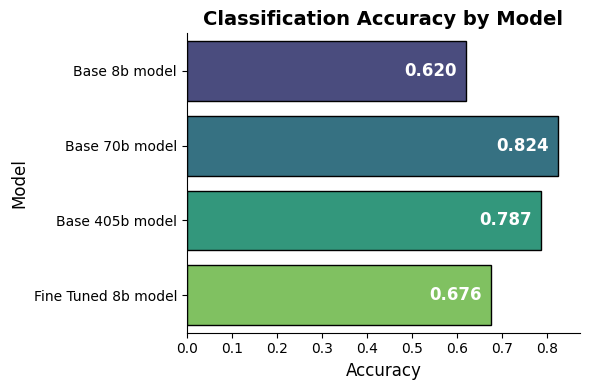

In [24]:
# Rename dictionary
rename_dict = {
    'answer_base_8B': 'Base 8b model',
    'answer_base_70B': 'Base 70b model',
    'answer_base_405B': 'Base 405b model',
    'answer_ft_8B': 'Fine Tuned 8b model',
}

# Calculate accuracy for each model with renamed keys
accuracies = {}
for name in rename_dict:
    accuracy = test_df.apply(lambda row: row[name] in row['sentiment'], axis=1).mean()
    accuracies[rename_dict[name]] = accuracy

# Horizontal bar chart
fig, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    y=list(accuracies.keys()),
    x=list(accuracies.values()),
    hue=list(accuracies.keys()),  # Add a hue based on the model names
    palette="viridis",
    edgecolor='black',
    ax=ax,
    legend=False  # Disable the unnecessary legend
)

# Add labels to bars
for i, bar in enumerate(ax.patches):
    ax.text(bar.get_width() - 0.02,
            bar.get_y() + bar.get_height() / 2,
            f"{list(accuracies.values())[i]:.3f}",
            ha='right', va='center', color='white', fontsize=12, fontweight='bold')

# Set plot aesthetics
ax.set_xlim(0, max(accuracies.values()) + 0.05)
ax.set_xlabel('Accuracy', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_title('Classification Accuracy by Model', fontsize=14, fontweight='bold')
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

## Conclusion

As you can see in the above chart, the fine-tuned model performed appreciably better than the base model. Remember that we optimized this tutorial for speed, and not for performance. Accordingly, if you increase the size of the phrasebank dataset sample taken and increase the number of epochs as hyperparameters, you will likely see substantially increased performance of the fine-tuned model, that rivals the performance of the base 70b model.

After you run through the tutorial once successfully, we encourage you to experiment with the hyperparameters, training data, and the system prompt, and the various models offered by kluster. Good luck!